In [1]:
%pip install Levenshtein
%pip install transformers
%pip install accelerate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 38.5 MB/s eta 0:00:00


In [2]:
# IMPORTS

import psutil
import json
import os
import random
import time
import torch
import uuid

from datetime import datetime
from Levenshtein import distance
from jinja2 import Template
from PIL import Image


import os
import re
import torch
from IPython.display import display
from diffusers import StableDiffusionPipeline
from diffusers import DPMSolverMultistepScheduler
from diffusers import AutoencoderKL

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

In [3]:
# VARIOUS HELPER FUNCTIONS

### SIMILARITY CALCULATIONS FOR TRACK NAMES

SIMILARITY_DISTANCE = 3
def are_tracks_similar(tracks):
    for i in range(len(tracks)):
        for j in range(i + 1, len(tracks)):
            if distance(tracks[i]['name'], tracks[j]['name']) < SIMILARITY_DISTANCE:
                return True
    return False

def similarity_groups(tracks):
    found_group = [False] * len(tracks)
    groups = []

    for i in range(len(tracks)):
        if found_group[i]:
            continue

        found_group[i] = True
        groups.append([tracks[i]])

        for j in range(i + 1, len(tracks)):
            if found_group[j]:
                continue
            if distance(tracks[i]['name'], tracks[j]['name']) < SIMILARITY_DISTANCE:
                found_group[j] = True

    return groups



In [4]:
# # GET ALBUM DATA
# file_id = "" # if need for a specific album, put the file name here

# if file_id == "":
#     album_files = os.listdir('/content/MSGAI/input/')
#     random_album_file = random.choice(album_files)
# else:
#     random_album_file = f'{file_id}.json'

# with open(f'MSGAI/input/{random_album_file}', 'r') as file:
#     album_data = json.load(file)

album_data = {
    "name": "Van Bommel",
    "id": "0tYUurZjmCZV3u1dKv0ghD",
    "date": "2022-07-08",
    "artists": [
        "Chily"
    ],
    "cover": "https://i.scdn.co/image/ab67616d0000b273e8f5f789fbda5464e05143fb",
    "genres": [],
    "label": "Columbia",
    "tracks": [
        {
            "name": "Van Bommel",
            "artists": [
                "Chily"
            ]
        },
        {
            "name": "Ca va ? Ca va !",
            "artists": [
                "Chily"
            ]
        },
        {
            "name": "Casser la baraque",
            "artists": [
                "Chily"
            ]
        },
        {
            "name": "Ma copine",
            "artists": [
                "Chily"
            ]
        },
        {
            "name": "O\u00f9 sont mes amis ? (feat. Tiakola)",
            "artists": [
                "Chily",
                "Tiakola"
            ]
        },
        {
            "name": "Nouveau dossier",
            "artists": [
                "Chily"
            ]
        },
        {
            "name": "B\u00e9b\u00e9 Na B\u00e9b\u00e9 (feat. Leto)",
            "artists": [
                "Chily",
                "Leto"
            ]
        },
        {
            "name": "Paris",
            "artists": [
                "Chily"
            ]
        },
        {
            "name": "Tiens ton pantalon",
            "artists": [
                "Chily"
            ]
        },
        {
            "name": "Pump L Up (feat. Guy2Bezbar)",
            "artists": [
                "Chily",
                "Guy2Bezbar"
            ]
        },
        {
            "name": "Dani",
            "artists": [
                "Chily"
            ]
        },
        {
            "name": "Big Meech",
            "artists": [
                "Chily"
            ]
        },
        {
            "name": "Dans la tempe",
            "artists": [
                "Chily"
            ]
        },
        {
            "name": "Formalit\u00e9s",
            "artists": [
                "Chily"
            ]
        },
        {
            "name": "Tu connais",
            "artists": [
                "Chily"
            ]
        },
        {
            "name": "Nicky (feat. MHD)",
            "artists": [
                "Chily",
                "MHD"
            ]
        },
        {
            "name": "Faut bosser (feat. Guy2Bezbar)",
            "artists": [
                "Chily",
                "Guy2Bezbar"
            ]
        },
        {
            "name": "Pimp",
            "artists": [
                "Chily"
            ]
        }
    ]
}

In [5]:
# POSITIVE PROMPT TEMPLATES

pos_prompt_templates = {}

pos_prompt_templates['1-long'] =  Template("""\
Album cover for this album:
Album name : {{ album.name }}
Artist{% if album.artists|length > 1 %}s{% endif %} : {{ album.artists | join(', ') }}
Release Date : {{ album.date }}
Label : {{ album.label }}
Tracks:
{% for track in album.tracks %}- {{ track.name }}\n{% endfor %}
""")

pos_prompt_templates['2-only-tracks'] =  Template("""\
Album cover for these tracks:
{% for track in album.tracks %}- {{ track.name }}\n{% endfor %}
""")

pos_prompt_templates['3-long-with-track-similarity'] =  Template("""\
Album cover for this album:
Album name : {{ album.name }}
Artist{% if album.artists|length > 1 %}s{% endif %} : {{ album.artists | join(', ') }}
Release Date : {{ album.date }}
Label : {{ album.label }}

{% if are_tracks_similar(album.tracks) %} Track format : {% for track in similarity_groups(album.tracks) %}- {{ track.name }}\n{% endfor %}
{% else %} Tracks:
{% for track in album.tracks %}- {{ track.name }}\n{% endfor %}{% endif %}
""")

In [6]:
# OTHER PARAMETERS

inference_steps = 20 # the lower the faster but loses in quality
guidance_scale = 10 # the higher the more it follows the prompt BUT loses in creativity
num_images_per_prompt = 3# Number of images to generate in parallel
BATCH_SIZE = 1
#MODELS = ['sd-legacy/stable-diffusion-v1-5', 'stabilityai/stable-diffusion-2']

In [7]:
# #LOAD MODEL

# Stable Diffusion model: https://huggingface.co/stabilityai/stable-diffusion-2
pipe = StableDiffusionPipeline.from_pretrained("stabilityai/stable-diffusion-2", torch_dtype=torch.float32)
pipe = pipe.to("cuda")  # Use "cpu" if CUDA is not available
pipe.scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config)

#to improve quality
vae = AutoencoderKL.from_pretrained("stabilityai/sd-vae-ft-mse", torch_dtype=torch.float32).to("cuda")
pipe.vae = vae

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model_index.json:   0%|          | 0.00/537 [00:00<?, ?B/s]

Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

text_encoder/config.json:   0%|          | 0.00/633 [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/345 [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.36G [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/824 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/909 [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/611 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.46G [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

In [56]:
torch.cuda.empty_cache()

  0%|          | 0/20 [00:00<?, ?it/s]

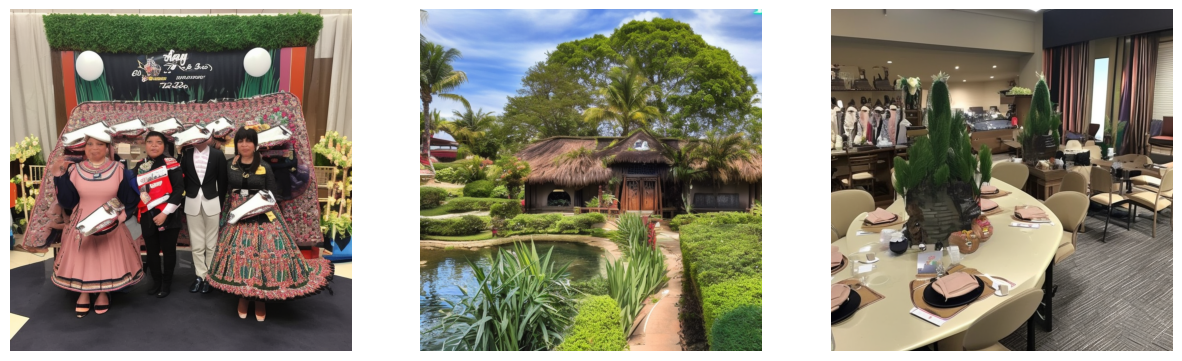

In [9]:
# RUNS

prompt = str(pos_prompt_templates['1-long'])

from PIL import Image
import matplotlib.pyplot as plt

images = pipe(
    prompt=prompt,
    negative_prompt="text",
    guidance_scale=7.5,
    num_inference_steps=20,
    num_images_per_prompt=3
).images

# Displaying all 3 images
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i, ax in enumerate(axes):
    ax.imshow(images[i])
    ax.axis('off')
plt.show()
